In [1]:
if 'google.colab' in str(get_ipython()):
    import sys
    from google.colab import drive, output
    drive.mount('/content/drive')

    !pip install umap-learn
    !pip install umap-learn[plot]
    !pip install holoviews

    !pip install joypy

    output.clear()
    print("Running on colab")
    %load_ext autoreload
    %autoreload 1
    %cd '/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project'
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Dataloader')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Modules')
elif "zmqshell" in str(get_ipython()):
    print("Running on MIRP")
    root = "/home/mirp_ai/Documents/Daniel_Nieto/PhD/AutoEncoders_Ecoacoustics"
    root_path = "/media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido"
else:
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    print("Running local")

Running on MIRP


In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import gc
gc.collect()  #

import datetime
import gc
import pandas as pd
import joypy

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler as Normalizer

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torchvision.datasets as datasets

from Zamuro_DataLoader import SoundscapeData
from Models import ConvAE as AE
from AE_training_functions import TestModel, TrainModel
from AE_Clustering import AE_Clustering 
from Modules.Clustering_Utils_Zamuro import plot_silhouette
from Modules.Clustering_Utils_Zamuro import plot_centroids
from Modules.Clustering_Utils_Zamuro import ClusteringResults

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from datetime import timedelta

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import pacmap

import warnings
warnings.filterwarnings("ignore")


import random
def _set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
_set_seed(1024)

/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/dist

In [3]:
model_type = "AE"
identifier = "batch_size_14_num_hiddens_64_"
day = 4
hour = 9
date_format = f"day_{day}_hour_{hour}"

model_name = f"{root}/Zamuro/temporal_zamuro/models/log_standarization_model_epochs_10/model_{model_type}_{identifier}_{date_format}_final.pth"
model = AE(num_hiddens=64).to(device)
model.load_state_dict(torch.load(f'{model_name}', map_location=torch.device('cpu')))


filters = {"rain_FI": "NO"}
dataset = SoundscapeData('media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido/',
                         dataframe_path="Complementary_Files/zamuro_audios.csv",
                         audio_length=12, ext="wav",
                         win_length=1028, filters=filters)

test_loader = DataLoader(dataset, batch_size=100)
iterator = iter(test_loader)
testing = TestModel(model, iterator, device=torch.device("cuda"))

/media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido/


In [4]:
audios = pd.read_csv(f"Complementary_Files/zamuro_audios_complete.csv", index_col=0)
recorders = pd.read_csv(f"Complementary_Files/zamuro_recorders_satelites.csv", index_col=0)
df_ae = pd.read_csv(f"temporal_zamuro/Features/New_df_ae_unflat.csv")
df_ae = df_ae[df_ae['location'] != 'RZUD06']
X = np.asarray(df_ae.loc[:,"0":"25919"])
X = np.reshape(X, [X.shape[0], 5, X.shape[1]//5])
X = np.mean(X, axis=1)
print(X.shape)

(52603, 5184)


day=5
df_day = df_ae[df_ae['day'].isin([day])]
X_day = np.asarray(df_day.loc[:,"0":"5183"])

Normalizer_ = Normalizer().fit(X_day)
X = Normalizer_.transform(X_day)

X.shape

In [5]:
df_ae.set_index("y", inplace=True)
df_ae = df_ae.join(audios[['longitud_IG', 'latitude_IG']], how='left')

## Conectividad en audios por días

In [ ]:
import pacmap
import networkx as nx
import matplotlib.pyplot as plt
import mplcyberpunk  # Estilo visual mejorado
from sklearn.datasets import make_blobs
from scipy.spatial import distance_matrix
import time

days = list(set(df_ae["day"]))

for day in days:
    df_day = df_ae[df_ae['day'].isin([day])]
    X_day = np.asarray(df_day.loc[:,"0":"25919"])
    X_day = np.reshape(X_day, [X_day.shape[0], 5, X_day.shape[1]//5])
    X_day = np.mean(X_day, axis=1)

    Normalizer_ = Normalizer().fit(X_day)
    X = Normalizer_.transform(X_day)

    # 🔹 Aplicar PacMAP para reducir a 2D

    print("Computing PacMAP features")
    start_time = time.time()
    pacmap_reducer = pacmap.PaCMAP(n_components=2, n_neighbors=75, MN_ratio=1, FP_ratio=20)
    X_pacmap = pacmap_reducer.fit_transform(X)
    print(f"PacMAP completed in {time.time() - start_time:.2f} secs.")

    plt.figure()
    plt.scatter(X_pacmap[:,0], X_pacmap[:,1], s=1, alpha=1)
    plt.title("PacMAP Projection")
    plt.show()

    # 🔹 Construir matriz de distancias de Hamming en el espacio reducido
    print("Computing Hamming distance matrix in PacMAP space...")
    start_time = time.time()
    distance_mat = distance_matrix(X_pacmap, X_pacmap, p=1)  # Distancia de Hamming en 2D
    print(f"Hamming distance computed in {time.time() - start_time:.2f} secs.")

    # 🔹 Crear grafo basado en distancia de Hamming en el espacio PacMAP
    print("Computing Graph...")
    G = nx.Graph()
    threshold = np.percentile(distance_mat, 5)  # Tomar un umbral bajo para conexiones cercanas
    graph_edges = []
    for i in range(len(X_pacmap)):
        for j in range(i + 1, len(X_pacmap)):
            if distance_mat[i, j] < threshold:
                G.add_edge(i, j)
                graph_edges.append((i, j))
    print(f"Graph computed with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

    # 🔹 Usar las coordenadas de PacMAP como layout
    print("Applying PacMAP-Based Layout...")
    start_time = time.time()
    pos_pacmap = {i: X_pacmap[i] for i in range(len(X_pacmap))}  # Usa PacMAP como layout
    print(f"PacMAP Layout completed in {time.time() - start_time:.2f} secs.")

    # 🔹 Graficar con mejor estilo
    plt.style.use("seaborn-whitegrid")  # Activar el estilo seaborn-whitegrid
    fig, ax = plt.subplots(figsize=(10, 8))
    nx.draw_networkx_nodes(G, pos_pacmap, node_size=5, node_color='black', alpha=0.8)
    nx.draw_networkx_edges(G, pos_pacmap, edgelist=graph_edges, width=0.3, edge_color="red", alpha=0.3)

    print("Graph plotted")

    # 🔹 Efectos visuales
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.title("Hamming Layout Edge Bundling (PacMAP)")
    plt.xlabel("PacMAP 1")
    plt.ylabel("PacMAP 2")
    plt.tight_layout()
    plt.savefig(f"temporal_zamuro/zamuro_connectivity_results/Days_Results/AE/PacMAP/connectivity_{str(day)}")
    plt.show()

## Conectividad en Grabadoras

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import Point, LineString
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import MinMaxScaler
from datashader.bundling import hammer_bundle
from scipy.special import softmax

print("Muestreando datos...")
sampled_df_ae = df_ae.sample(frac=0.02, random_state=42)  # Tomar el 5% de los datos para prueba rápida
# sampled_df_ae = df_ae  # Tomar el 5% de los datos para prueba rápida


print("Calculando características acústicas...")
X = np.asarray(sampled_df_ae.loc[:, "0":"25919"])
X = np.reshape(X, [X.shape[0], 5, X.shape[1]//5])
X = np.mean(X, axis=1)
Normalizer_ = Normalizer().fit(X)
X = Normalizer_.transform(X)

print("Computando PacMAP...")
pacmap_reducer = pacmap.PaCMAP(n_components=2, n_neighbors=75, MN_ratio=1, FP_ratio=20)
X_pacmap = pacmap_reducer.fit_transform(X)
print("PacMAP completado")




In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import Point, LineString
from sklearn.neighbors import kneighbors_graph
from scipy.special import softmax

print("Extrayendo datos de sampled_df_ae...")
grabadoras = sampled_df_ae['location'].unique()
n_grabadoras = len(grabadoras)
location_map = {loc: i for i, loc in enumerate(grabadoras)}
sampled_df_ae['grabadora_id'] = sampled_df_ae['location'].map(location_map)

print("Extrayendo coordenadas de grabadoras...")
coordenadas_grabadoras = {
    location_map[loc]: Point(sampled_df_ae[sampled_df_ae['location'] == loc]["longitud_IG"].mean(), 
                             sampled_df_ae[sampled_df_ae['location'] == loc]["latitude_IG"].mean())
    for loc in grabadoras
}

print("Construyendo grafo de conectividad entre audios...")
X_audio = X_pacmap
audio_graph = kneighbors_graph(X_audio, n_neighbors=50, mode="connectivity", include_self=False)
G_audio = nx.from_scipy_sparse_array(audio_graph)

print("Construyendo grafo de grabadoras basado en conexiones de audio...")
G_grabadoras = nx.Graph()
for i in range(n_grabadoras):
    G_grabadoras.add_node(i, pos=coordenadas_grabadoras[i])

print("Definiendo función de atención basada en conexiones entre grabadoras...")
audio_counts = {}
for i, j in G_audio.edges():
    g1, g2 = sampled_df_ae.iloc[i]['grabadora_id'], sampled_df_ae.iloc[j]['grabadora_id']
    if g1 != g2:
        audio_counts[(g1, g2)] = audio_counts.get((g1, g2), 0) + 1

# Agregar conexiones al grafo de grabadoras
for (g1, g2), count in audio_counts.items():
    G_grabadoras.add_edge(g1, g2, weight=count)

print("Aplicando Softmax por grabadora...")
# Diccionario para almacenar los pesos normalizados por cada grabadora
normalized_weights = {}

# Aplicar softmax a las conexiones de cada grabadora individualmente
for grabadora in G_grabadoras.nodes():
    vecinos = list(G_grabadoras[grabadora])
    if not vecinos:
        continue  # Si no tiene conexiones, continuar

    # Obtener los pesos originales de las conexiones
    pesos = np.array([G_grabadoras[grabadora][v]['weight'] for v in vecinos], dtype=np.float32)
    
    # Aplicar softmax a los pesos de esta grabadora
    pesos_softmax = softmax(pesos)

    # Asignar los pesos normalizados al grafo
    for idx, v in enumerate(vecinos):
        normalized_weights[(grabadora, v)] = pesos_softmax[idx]

# Aplicar umbral y actualizar el grafo
threshold = 0.05  # Ajusta según necesidad
edges_to_remove = []

for (g1, g2), weight in normalized_weights.items():
    if weight < threshold:
        edges_to_remove.append((g1, g2))  # Marcar para eliminar
    else:
        G_grabadoras[g1][g2]['weight'] = weight  # Asignar peso normalizado

# Eliminar conexiones débiles
G_grabadoras.remove_edges_from(edges_to_remove)

print(f"Grafo de grabadoras actualizado: {G_grabadoras.number_of_nodes()} nodos, {G_grabadoras.number_of_edges()} conexiones después del umbral.")

print("Visualizando grafo de grabadoras...")
fig, ax = plt.subplots(figsize=(10, 6))

# Crear GeoDataFrame para visualizar las grabadoras
geo_df = gpd.GeoDataFrame({"grabadora": list(coordenadas_grabadoras.keys()), "geometry": list(coordenadas_grabadoras.values())})
geo_df.plot(ax=ax, color='red', markersize=50, label="Grabadoras")

# Obtener valores de pesos para escalar el grosor de las conexiones
edge_weights = [G_grabadoras[i][j]['weight'] for i, j in G_grabadoras.edges()]
edge_weights = np.array(edge_weights)

# Normalizar los pesos para ajustar el grosor de línea
if len(edge_weights) > 0:
    min_weight = edge_weights.min()
    max_weight = edge_weights.max()
    if max_weight > min_weight:
        edge_weights = 1 + 5 * (edge_weights - min_weight) / (max_weight - min_weight)
    else:
        edge_weights = np.ones_like(edge_weights)  # Evitar división por cero

# Dibujar las conexiones con grosor proporcional al peso
for idx, (i, j) in enumerate(G_grabadoras.edges()):
    if i in coordenadas_grabadoras and j in coordenadas_grabadoras:
        line = LineString([coordenadas_grabadoras[i], coordenadas_grabadoras[j]])
        gpd.GeoSeries([line]).plot(ax=ax, color='blue', linewidth=edge_weights[idx], alpha=0.6)

# Obtener etiquetas de las grabadoras desde sampled_df_ae
labels = sampled_df_ae.set_index("grabadora_id")["location"].to_dict()

# Dibujar etiquetas sobre los nodos en el grafo
for grabadora_id, point in coordenadas_grabadoras.items():
    ax.text(point.x, point.y, labels[grabadora_id], fontsize=5, ha='right', color='black')

ax.set_title(f"Mapa de conectividad entre grabadoras (Threshold={threshold})")
plt.legend()
plt.show()

Transformando coordenadas de grabadoras al CRS del raster...
Construyendo grafo de audio basado en vecinos cercanos...
Construyendo grafo de grabadoras basado en conexiones de audio...
Aplicando Softmax por grabadora...
Grafo de grabadoras actualizado: 89 nodos, 7 conexiones después del umbral.


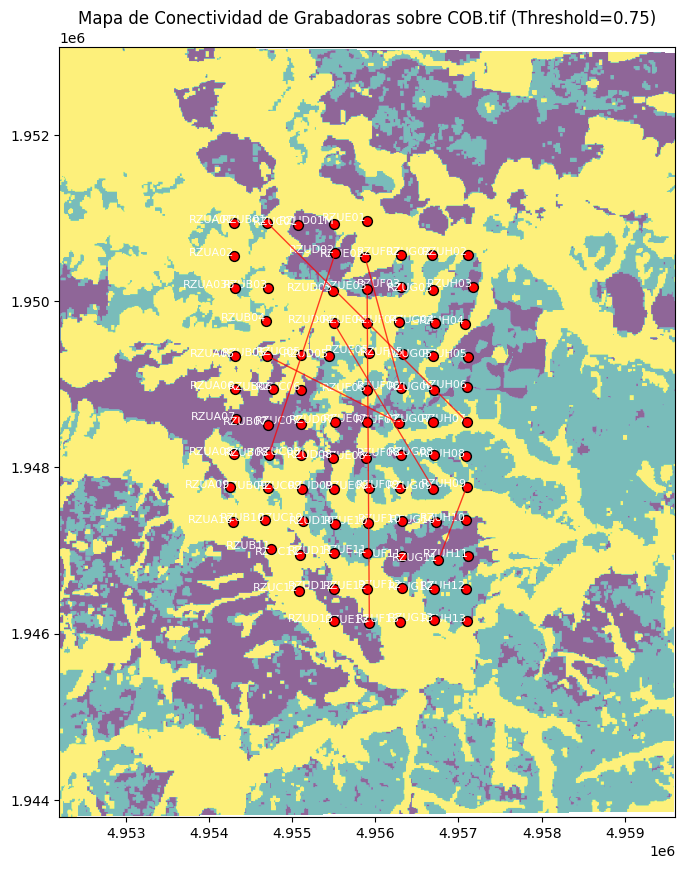

In [172]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import rasterio
from rasterio.plot import show
from shapely.geometry import Point, LineString
from sklearn.neighbors import kneighbors_graph
from scipy.special import softmax

# ---- Cargar el raster COB.tif ----
raster_path = "Complementary_Files/COB.tif"
with rasterio.open(raster_path) as src:
    raster_data = src.read(1)  # Leer la primera banda
    raster_bounds = src.bounds  # Obtener el bounding box del raster
    raster_crs = src.crs  # Obtener la proyección del raster

# ---- Transformar coordenadas de grabadoras al sistema del raster ----
print("Transformando coordenadas de grabadoras al CRS del raster...")
gdf_grabadoras = gpd.GeoDataFrame(
    {"grabadora": sampled_df_ae['location'].unique()},
    geometry=[Point(sampled_df_ae[sampled_df_ae['location'] == loc]["longitud_IG"].mean(), 
                    sampled_df_ae[sampled_df_ae['location'] == loc]["latitude_IG"].mean()) 
              for loc in sampled_df_ae['location'].unique()],
    crs="EPSG:4326"  # Sistema original (Lat/Lon)
)

# Transformar al sistema de coordenadas del raster
gdf_grabadoras = gdf_grabadoras.to_crs(raster_crs)

# Guardar coordenadas transformadas
coordenadas_grabadoras = {row.grabadora: row.geometry for _, row in gdf_grabadoras.iterrows()}

# ---- Construcción del grafo de audios basado en vecinos cercanos ----
n_neighbors = 50
X_audio = X_pacmap  # Usar la proyección PaCMAP
print("Construyendo grafo de audio basado en vecinos cercanos...")
audio_graph = kneighbors_graph(X_audio, n_neighbors=n_neighbors, mode="connectivity", include_self=False)
G_audio = nx.from_scipy_sparse_array(audio_graph)

# ---- Construcción del grafo de grabadoras ----
print("Construyendo grafo de grabadoras basado en conexiones de audio...")
G_grabadoras = nx.Graph()

# Agregar nodos con nombres de grabadoras
for grabadora in coordenadas_grabadoras:
    G_grabadoras.add_node(grabadora, pos=(coordenadas_grabadoras[grabadora].x, coordenadas_grabadoras[grabadora].y))

# ---- Agregar conexiones al grafo de grabadoras usando nombres ----
audio_counts = {}
for i, j in G_audio.edges():
    g1, g2 = sampled_df_ae.iloc[i]['location'], sampled_df_ae.iloc[j]['location']
    if g1 != g2:
        audio_counts[(g1, g2)] = audio_counts.get((g1, g2), 0) + 1

# Agregar conexiones con conteo sin normalizar
for (g1, g2), count in audio_counts.items():
    if g1 in G_grabadoras and g2 in G_grabadoras:
        G_grabadoras.add_edge(g1, g2, weight=count)

# ---- Aplicando Softmax por grabadora ----
print("Aplicando Softmax por grabadora...")
normalized_weights = {}

for grabadora in G_grabadoras.nodes():
    vecinos = list(G_grabadoras[grabadora])
    if not vecinos:
        continue

    pesos = np.array([G_grabadoras[grabadora][v]['weight'] for v in vecinos], dtype=np.float32)
    pesos_softmax = softmax(pesos)

    for idx, v in enumerate(vecinos):
        normalized_weights[(grabadora, v)] = pesos_softmax[idx]

# ---- Aplicar umbral y actualizar el grafo ----
threshold = 0.75
edges_to_remove = []

for (g1, g2), weight in normalized_weights.items():
    if weight < threshold:
        edges_to_remove.append((g1, g2))
    else:
        G_grabadoras[g1][g2]['weight'] = weight

G_grabadoras.remove_edges_from(edges_to_remove)

print(f"Grafo de grabadoras actualizado: {G_grabadoras.number_of_nodes()} nodos, {G_grabadoras.number_of_edges()} conexiones después del umbral.")

# ---- Visualización ----
fig, ax = plt.subplots(figsize=(10, 10))

# Mostrar el raster de fondo
with rasterio.open(raster_path) as src:
    show(src, ax=ax, extent=raster_bounds, alpha=0.6)

# Dibujar nodos con nombres correctos
for grabadora, pos in coordenadas_grabadoras.items():
    ax.scatter(pos.x, pos.y, color='red', s=50, edgecolors='black', zorder=3)
    ax.text(pos.x, pos.y, grabadora, fontsize=8, ha='right', color='black', bbox=dict(facecolor='none', alpha=0.5, edgecolor='none'))
    

# Dibujar los edges con `ax.plot()` y grosor proporcional al peso
for i, j in G_grabadoras.edges():
    if i in coordenadas_grabadoras and j in coordenadas_grabadoras:
        x_values = [coordenadas_grabadoras[i].x, coordenadas_grabadoras[j].x]
        y_values = [coordenadas_grabadoras[i].y, coordenadas_grabadoras[j].y]
        weight = G_grabadoras[i][j]['weight']
        ax.plot(x_values, y_values, color='red', linewidth=weight, alpha=0.75, zorder=3)
        

ax.set_title(f"Mapa de Conectividad de Grabadoras sobre COB.tif (Threshold={threshold})")
plt.show()


## Edge Bundle

Aplicando Hammer Edge Bundling...


<AxesSubplot: xlabel='x'>

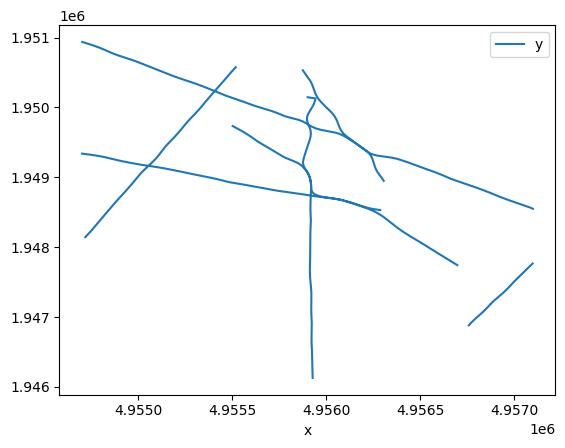

In [173]:
print("Aplicando Hammer Edge Bundling...")
edge_list = [(u, v, G_grabadoras.edges[u, v]['weight']) for u, v in G_grabadoras.edges()]
node_positions = {n: (p.x, p.y) for n, p in coordenadas_grabadoras.items()}
import numpy.lib.recfunctions as rfn

# Convertir node_positions_array a un array estructurado con nombres de campo
node_positions_array = np.array(
    list(node_positions.values()), 
    dtype=[('x', np.float32), ('y', np.float32)]
)
edge_indices = np.array([(u, v) for u, v in G_grabadoras.edges()])

# Convertir node_positions a un DataFrame
node_positions_df = pd.DataFrame.from_dict(
    node_positions, orient="index", columns=["x", "y"]
)
node_positions_df.index.name = "node_id"  # Asegurar que el índice tenga un nombre

# Convertir edge_indices a un DataFrame
edge_indices_df = pd.DataFrame(
    [(u, v) for u, v in G_grabadoras.edges()], columns=["source", "target"]
)

bundled_edges = hammer_bundle(node_positions_df, edge_indices_df)
# Asegurarnos de que bundled_edges sea una lista de listas de puntos
bundled_edges.plot(x="x", y="y")

## Conectividad en grabadoras por días

Muestreando datos...
Calculando características acústicas...
Computando PacMAP...
PacMAP completado
Extrayendo datos de sampled_df_ae...
Extrayendo coordenadas de grabadoras...
Construyendo grafo de conectividad entre audios...
Construyendo grafo de grabadoras basado en conexiones de audio...
Definiendo función de atención basada en conexiones entre grabadoras...
Aplicando Softmax por grabadora...
Grafo de grabadoras actualizado: 90 nodos, 16 conexiones después del umbral.
Visualizando grafo de grabadoras...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


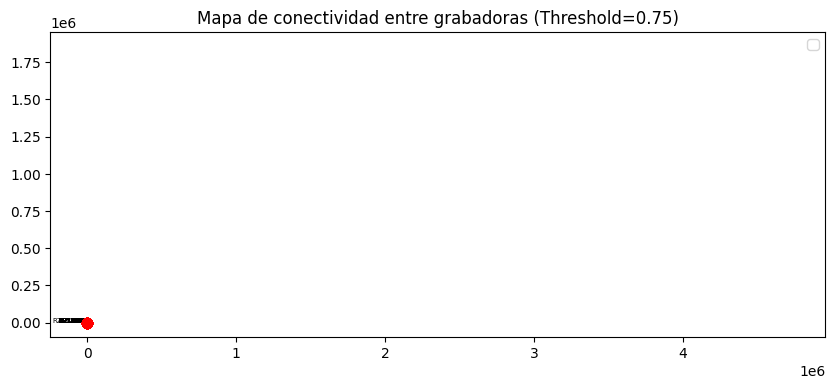

In [57]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import Point, LineString
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import MinMaxScaler
from datashader.bundling import hammer_bundle
from scipy.special import softmax

days = list(set(df_ae["day"]))
for day in days[4:5]:

# day = 8
    grabadoras_original = df_ae['location'].unique()
    location_map = {loc: i for i, loc in enumerate(grabadoras_original)}
    coordenadas_grabadoras_original = {
        location_map[loc]: Point(df_ae[df_ae['location'] == loc]["longitud_IG"].mean(), 
                                 df_ae[df_ae['location'] == loc]["latitude_IG"].mean())
        for loc in grabadoras_original
    }

    print("Muestreando datos...")
    # sampled_df_ae = df_ae.sample(frac=0.02, random_state=42)  # Tomar el 5% de los datos para prueba rápida
    sampled_df_ae = df_ae[df_ae['day'].isin([day])]


    print("Calculando características acústicas...")
    X_day = np.asarray(sampled_df_ae.loc[:,"0":"25919"])
    X_day = np.reshape(X_day, [X_day.shape[0], 5, X_day.shape[1]//5])
    X_day = np.mean(X_day, axis=1)
    Normalizer_ = Normalizer().fit(X_day)
    X_day = Normalizer_.transform(X_day)


    print("Computando PacMAP...")
    pacmap_reducer = pacmap.PaCMAP(n_components=2, n_neighbors=75, MN_ratio=1, FP_ratio=20)
    X_pacmap = pacmap_reducer.fit_transform(X_day)
    print("PacMAP completado")

    print("Extrayendo datos de sampled_df_ae...")
    grabadoras = sampled_df_ae['location'].unique()
    n_grabadoras = len(grabadoras)
    location_map = {loc: i for i, loc in enumerate(grabadoras)}
    sampled_df_ae['grabadora_id'] = sampled_df_ae['location'].map(location_map)

    print("Extrayendo coordenadas de grabadoras...")
    coordenadas_grabadoras = {
        location_map[loc]: Point(sampled_df_ae[sampled_df_ae['location'] == loc]["longitud_IG"].mean(), 
                                 sampled_df_ae[sampled_df_ae['location'] == loc]["latitude_IG"].mean())
        for loc in grabadoras
    }

    print("Construyendo grafo de conectividad entre audios...")
    X_audio = X_pacmap
    audio_graph = kneighbors_graph(X_audio, n_neighbors=5, mode="connectivity", include_self=False)
    G_audio = nx.from_scipy_sparse_array(audio_graph)

    print("Construyendo grafo de grabadoras basado en conexiones de audio...")
    G_grabadoras = nx.Graph()
    for i in range(n_grabadoras):
        G_grabadoras.add_node(i, pos=coordenadas_grabadoras[i])

    print("Definiendo función de atención basada en conexiones entre grabadoras...")
    audio_counts = {}
    for i, j in G_audio.edges():
        g1, g2 = sampled_df_ae.iloc[i]['grabadora_id'], sampled_df_ae.iloc[j]['grabadora_id']
        if g1 != g2:
            audio_counts[(g1, g2)] = audio_counts.get((g1, g2), 0) + 1

    # Agregar conexiones al grafo de grabadoras
    for (g1, g2), count in audio_counts.items():
        G_grabadoras.add_edge(g1, g2, weight=count)

    print("Aplicando Softmax por grabadora...")
    # Diccionario para almacenar los pesos normalizados por cada grabadora
    normalized_weights = {}

    # Aplicar softmax a las conexiones de cada grabadora individualmente
    for grabadora in G_grabadoras.nodes():
        vecinos = list(G_grabadoras[grabadora])
        if not vecinos:
            continue  # Si no tiene conexiones, continuar

        # Obtener los pesos originales de las conexiones
        pesos = np.array([G_grabadoras[grabadora][v]['weight'] for v in vecinos], dtype=np.float32)

        # Aplicar softmax a los pesos de esta grabadora
        pesos_softmax = softmax(pesos)

        # Asignar los pesos normalizados al grafo
        for idx, v in enumerate(vecinos):
            normalized_weights[(grabadora, v)] = pesos_softmax[idx]

    # Aplicar umbral y actualizar el grafo
    threshold = 0.75  # Ajusta según necesidad
    edges_to_remove = []

    for (g1, g2), weight in normalized_weights.items():
        if weight < threshold:
            edges_to_remove.append((g1, g2))  # Marcar para eliminar
        else:
            G_grabadoras[g1][g2]['weight'] = weight  # Asignar peso normalizado

    # Eliminar conexiones débiles
    G_grabadoras.remove_edges_from(edges_to_remove)

    print(f"Grafo de grabadoras actualizado: {G_grabadoras.number_of_nodes()} nodos, {G_grabadoras.number_of_edges()} conexiones después del umbral.")

    print("Visualizando grafo de grabadoras...")
    fig, ax = plt.subplots(figsize=(10, 6))

    # Crear GeoDataFrame para visualizar las grabadoras
    geo_df = gpd.GeoDataFrame({"grabadora": list(coordenadas_grabadoras.keys()), "geometry": list(coordenadas_grabadoras.values())})
    geo_df.plot(ax=ax, color='red', markersize=50)

    # Obtener valores de pesos para escalar el grosor de las conexiones
    edge_weights = [G_grabadoras[i][j]['weight'] for i, j in G_grabadoras.edges()]
    edge_weights = np.array(edge_weights)

    # Normalizar los pesos para ajustar el grosor de línea
    if len(edge_weights) > 0:
        min_weight = edge_weights.min()
        max_weight = edge_weights.max()
        if max_weight > min_weight:
            edge_weights = 1 + 5 * (edge_weights - min_weight) / (max_weight - min_weight)
        else:
            edge_weights = np.ones_like(edge_weights)  # Evitar división por cero

    # Dibujar las conexiones con grosor proporcional al peso
    for idx, (i, j) in enumerate(G_grabadoras.edges()):
        if i in coordenadas_grabadoras and j in coordenadas_grabadoras:
            line = LineString([coordenadas_grabadoras[i], coordenadas_grabadoras[j]])
            gpd.GeoSeries([line]).plot(ax=ax, color='blue', linewidth=edge_weights[idx], alpha=0.6)
            
    # Obtener etiquetas de las grabadoras desde sampled_df_ae
    labels = sampled_df_ae.set_index("grabadora_id")["location"].to_dict()
    
    # Mostrar el raster de fondo
    with rasterio.open(raster_path) as src:
        show(src, ax=ax, extent=raster_bounds, alpha=0.6)

    # Dibujar etiquetas sobre los nodos en el grafo
    for grabadora_id, point in coordenadas_grabadoras.items():
        ax.text(point.x, point.y, labels[grabadora_id], fontsize=5, ha='right', color='black')
        
    for grabadora_id, point in coordenadas_grabadoras_original.items():
        ax.scatter(point.x, point.y, color='red', s=50, zorder=3) 

    ax.set_title(f"Mapa de conectividad entre grabadoras (Threshold={threshold})")
    plt.legend()
    plt.savefig(f"temporal_zamuro/zamuro_connectivity_results/Days_Results/AE/By_recorders/recorder_connectivity_graph_{day}_nn_5")
    plt.show()

Transformando coordenadas de grabadoras a ESRI:103599...
Construyendo grafo de grabadoras basado en conexiones de audio...
Definiendo función de atención basada en conexiones entre grabadoras...
Aplicando Softmax por grabadora...
Grafo de grabadoras actualizado: 180 nodos, 16 conexiones después del umbral.


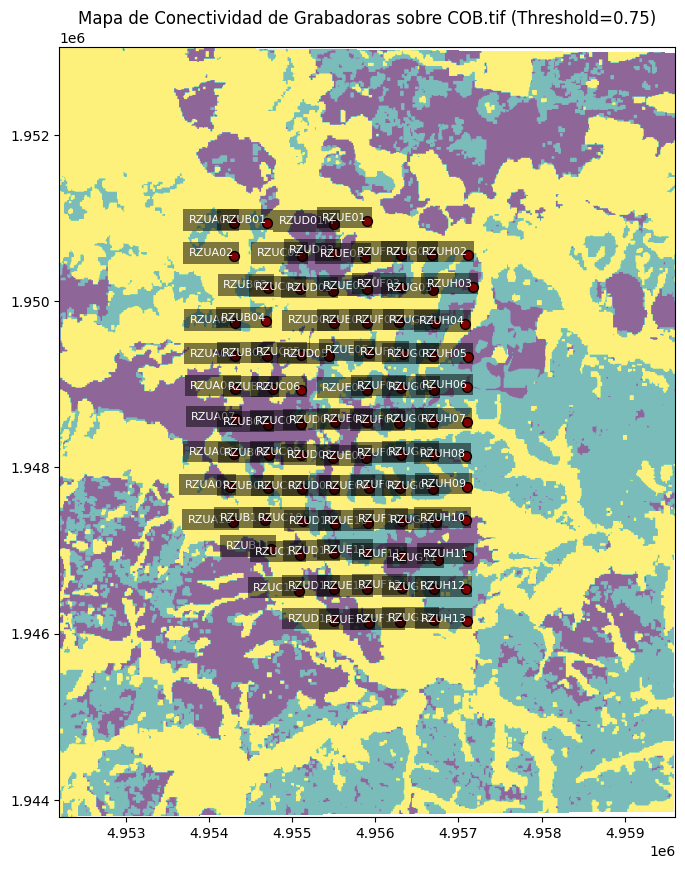

In [62]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import rasterio
from rasterio.plot import show
from shapely.geometry import Point, LineString
from sklearn.neighbors import kneighbors_graph
from scipy.special import softmax
from pyproj import CRS

# Cargar el raster COB.tif
raster_path = "Complementary_Files/COB.tif"
with rasterio.open(raster_path) as src:
    raster_data = src.read(1)  # Leer la primera banda
    raster_bounds = src.bounds  # Obtener el bounding box del raster
    raster_crs = src.crs  # Obtener la proyección del raster

# ---- Transformar coordenadas de grabadoras a ESRI:103599 ----
print("Transformando coordenadas de grabadoras a ESRI:103599...")
gdf_grabadoras = gpd.GeoDataFrame(
    {"grabadora": sampled_df_ae['location'].unique()},
    geometry=[Point(sampled_df_ae[sampled_df_ae['location'] == loc]["longitud_IG"].mean(), 
                    sampled_df_ae[sampled_df_ae['location'] == loc]["latitude_IG"].mean()) 
              for loc in sampled_df_ae['location'].unique()],
    crs="EPSG:4326"  # Sistema original (Lat/Lon)
)

# Transformar al sistema de coordenadas del raster
gdf_grabadoras = gdf_grabadoras.to_crs(raster_crs)

# Guardar coordenadas transformadas en un diccionario
coordenadas_grabadoras = {
    gdf_grabadoras.iloc[i].grabadora: gdf_grabadoras.iloc[i].geometry for i in range(len(gdf_grabadoras))
}

# ---- Construcción del grafo de grabadoras ----
print("Construyendo grafo de grabadoras basado en conexiones de audio...")
G_grabadoras = nx.Graph()
for grabadora in coordenadas_grabadoras:
    G_grabadoras.add_node(grabadora, pos=(coordenadas_grabadoras[grabadora].x, coordenadas_grabadoras[grabadora].y))

# Conteo de conexiones entre grabadoras a partir del grafo de audios
print("Definiendo función de atención basada en conexiones entre grabadoras...")
audio_counts = {}
for i, j in G_audio.edges():
    g1, g2 = sampled_df_ae.iloc[i]['grabadora_id'], sampled_df_ae.iloc[j]['grabadora_id']
    if g1 != g2:
        audio_counts[(g1, g2)] = audio_counts.get((g1, g2), 0) + 1

# Agregar conexiones al grafo de grabadoras
for (g1, g2), count in audio_counts.items():
    G_grabadoras.add_edge(g1, g2, weight=count)

print("Aplicando Softmax por grabadora...")
# Diccionario para almacenar los pesos normalizados por cada grabadora
normalized_weights = {}

# Aplicar softmax a las conexiones de cada grabadora individualmente
for grabadora in G_grabadoras.nodes():
    vecinos = list(G_grabadoras[grabadora])
    if not vecinos:
        continue  # Si no tiene conexiones, continuar

    # Obtener los pesos originales de las conexiones
    pesos = np.array([G_grabadoras[grabadora][v]['weight'] for v in vecinos], dtype=np.float32)

    # Aplicar softmax a los pesos de esta grabadora
    pesos_softmax = softmax(pesos)

    # Asignar los pesos normalizados al grafo
    for idx, v in enumerate(vecinos):
        normalized_weights[(grabadora, v)] = pesos_softmax[idx]

# Aplicar umbral y actualizar el grafo
threshold = 0.75  # Ajusta según necesidad
edges_to_remove = []

for (g1, g2), weight in normalized_weights.items():
    if weight < threshold:
        edges_to_remove.append((g1, g2))  # Marcar para eliminar
    else:
        G_grabadoras[g1][g2]['weight'] = weight  # Asignar peso normalizado

# Eliminar conexiones débiles
G_grabadoras.remove_edges_from(edges_to_remove)

print(f"Grafo de grabadoras actualizado: {G_grabadoras.number_of_nodes()} nodos, {G_grabadoras.number_of_edges()} conexiones después del umbral.")

# ---- Visualización ----
fig, ax = plt.subplots(figsize=(10, 10))

# Mostrar el raster de fondo
with rasterio.open(raster_path) as src:
    show(src, ax=ax, extent=raster_bounds, alpha=0.6)

# Dibujar los nodos de las grabadoras
for grabadora, pos in coordenadas_grabadoras.items():
    ax.scatter(pos.x, pos.y, color='red', s=50, edgecolors='black', zorder=3)
    ax.text(pos.x, pos.y, grabadora, fontsize=8, ha='right', color='white', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))

# Dibujar los edges con grosor proporcional al peso
for i, j in G_grabadoras.edges():
    if i in coordenadas_grabadoras and j in coordenadas_grabadoras:
        line = LineString([coordenadas_grabadoras[i], coordenadas_grabadoras[j]])
        weight = G_grabadoras[i][j]['weight']
        gpd.GeoSeries([line]).plot(ax=ax, color='black', linewidth = max(1.5, weight * 10) , alpha=0.7, zorder=2)

ax.set_title(f"Mapa de Conectividad de Grabadoras sobre COB.tif (Threshold={threshold})")
plt.show()



Transformando coordenadas de grabadoras al CRS del raster...
Construyendo grafo de grabadoras basado en conexiones de audio...
Aplicando Softmax por grabadora...
Grafo de grabadoras actualizado: 90 nodos, 16 conexiones después del umbral.


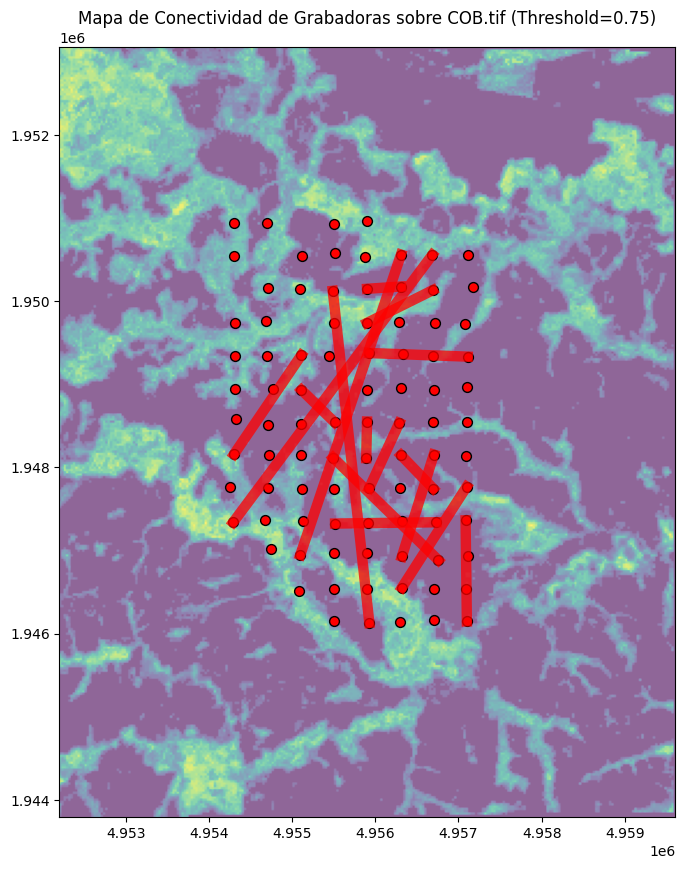

In [158]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import rasterio
from rasterio.plot import show
from shapely.geometry import Point, LineString
from sklearn.neighbors import kneighbors_graph
from scipy.special import softmax

# ---- Cargar el raster COB.tif ----
raster_path = "Complementary_Files/AD.tif"
with rasterio.open(raster_path) as src:
    raster_data = src.read(1)  # Leer la primera banda
    raster_bounds = src.bounds  # Obtener el bounding box del raster
    raster_crs = src.crs  # Obtener la proyección del raster

# ---- Transformar coordenadas de grabadoras al sistema del raster ----
print("Transformando coordenadas de grabadoras al CRS del raster...")
gdf_grabadoras = gpd.GeoDataFrame(
    {"grabadora": sampled_df_ae['location'].unique()},
    geometry=[Point(sampled_df_ae[sampled_df_ae['location'] == loc]["longitud_IG"].mean(), 
                    sampled_df_ae[sampled_df_ae['location'] == loc]["latitude_IG"].mean()) 
              for loc in sampled_df_ae['location'].unique()],
    crs="EPSG:4326"  # Sistema original (Lat/Lon)
)

# Transformar al sistema de coordenadas del raster
gdf_grabadoras = gdf_grabadoras.to_crs(raster_crs)

# Guardar coordenadas transformadas en un diccionario
coordenadas_grabadoras = {
    gdf_grabadoras.iloc[i].grabadora: gdf_grabadoras.iloc[i].geometry for i in range(len(gdf_grabadoras))
}

# ---- Construcción del grafo de grabadoras ----
print("Construyendo grafo de grabadoras basado en conexiones de audio...")
G_grabadoras = nx.Graph()

# Agregar nodos con nombres de grabadoras
for grabadora in coordenadas_grabadoras:
    G_grabadoras.add_node(grabadora, pos=(coordenadas_grabadoras[grabadora].x, coordenadas_grabadoras[grabadora].y))

# ---- Agregar conexiones al grafo de grabadoras usando nombres ----
audio_counts = {}
for i, j in G_audio.edges():
    g1, g2 = sampled_df_ae.iloc[i]['location'], sampled_df_ae.iloc[j]['location']
    if g1 != g2:
        audio_counts[(g1, g2)] = audio_counts.get((g1, g2), 0) + 1

# Agregar conexiones con conteo sin normalizar
for (g1, g2), count in audio_counts.items():
    if g1 in G_grabadoras and g2 in G_grabadoras:
        G_grabadoras.add_edge(g1, g2, weight=count)

# ---- Aplicando Softmax por grabadora ----
print("Aplicando Softmax por grabadora...")
normalized_weights = {}

for grabadora in G_grabadoras.nodes():
    vecinos = list(G_grabadoras[grabadora])
    if not vecinos:
        continue

    pesos = np.array([G_grabadoras[grabadora][v]['weight'] for v in vecinos], dtype=np.float32)
    pesos_softmax = softmax(pesos)

    for idx, v in enumerate(vecinos):
        normalized_weights[(grabadora, v)] = pesos_softmax[idx]

# ---- Aplicar umbral y actualizar el grafo ----
threshold = 0.75
edges_to_remove = []

for (g1, g2), weight in normalized_weights.items():
    if weight < threshold:
        edges_to_remove.append((g1, g2))
    else:
        G_grabadoras[g1][g2]['weight'] = weight

G_grabadoras.remove_edges_from(edges_to_remove)

print(f"Grafo de grabadoras actualizado: {G_grabadoras.number_of_nodes()} nodos, {G_grabadoras.number_of_edges()} conexiones después del umbral.")

# ---- Visualización ----
fig, ax = plt.subplots(figsize=(10, 10))

# Mostrar el raster de fondo
with rasterio.open(raster_path) as src:
    show(src, ax=ax, extent=raster_bounds, alpha=0.6)

# Dibujar nodos con nombres correctos
for grabadora, pos in coordenadas_grabadoras.items():
    ax.scatter(pos.x, pos.y, color='red', s=50, edgecolors='black', zorder=3)
#     ax.text(pos.x, pos.y, grabadora, fontsize=8, ha='right', color='white', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))

# Dibujar los edges con `ax.plot()` y grosor proporcional al peso
for i, j in G_grabadoras.edges():
    if i in coordenadas_grabadoras and j in coordenadas_grabadoras:
        x_values = [coordenadas_grabadoras[i].x, coordenadas_grabadoras[j].x]
        y_values = [coordenadas_grabadoras[i].y, coordenadas_grabadoras[j].y]
        weight = G_grabadoras[i][j]['weight']
        
        ax.plot(x_values, y_values, color='red', linewidth=max(1.5, weight)*5, alpha=0.75, zorder=3)

ax.set_title(f"Mapa de Conectividad de Grabadoras sobre COB.tif (Threshold={threshold})")
plt.show()


Top 10 conexiones con mayor similitud de audio:
   Grabadora 1 Grabadora 2      Peso
0       RZUA08      RZUC05  1.000000
5       RZUD08      RZUG11  1.000000
14      RZUF12      RZUH09  1.000000
10      RZUE07      RZUE08  1.000000
8       RZUE04      RZUG03  1.000000
9       RZUE05      RZUH05  0.999999
11      RZUE09      RZUF07  0.999999
13      RZUF11      RZUG08  0.999997
15      RZUH10      RZUH13  0.999983
3       RZUC11      RZUF02  0.999959


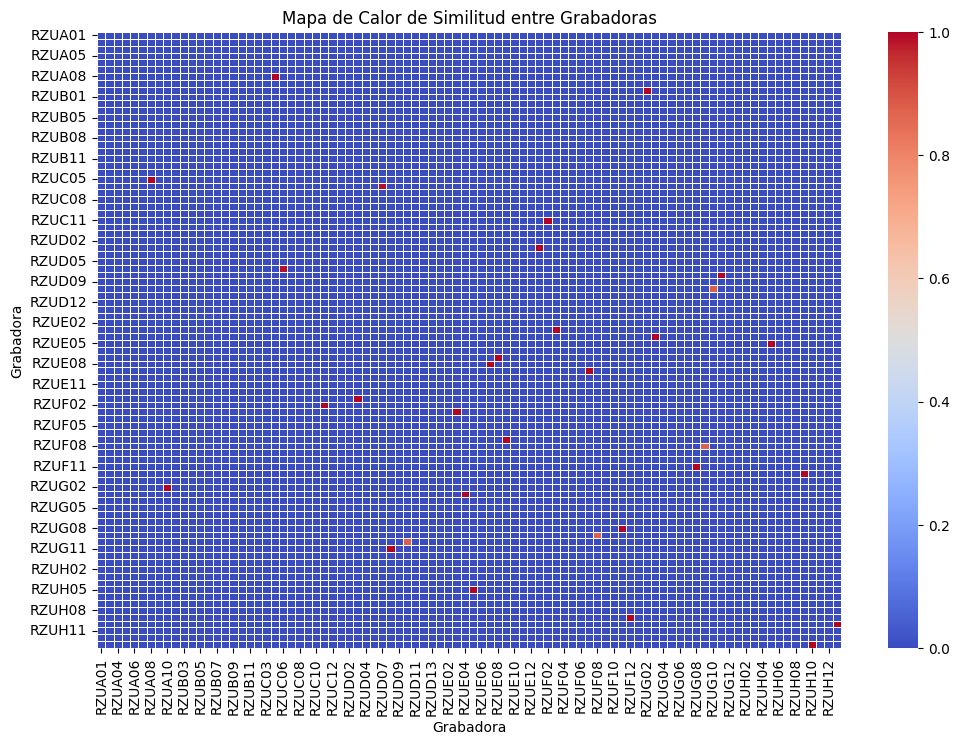

In [151]:
import seaborn as sns
import pandas as pd

# Extraer conexiones del grafo con sus pesos
edges_data = [(i, j, G_grabadoras[i][j]['weight']) for i, j in G_grabadoras.edges()]

# Convertir a DataFrame y ordenar por peso
df_connections = pd.DataFrame(edges_data, columns=['Grabadora 1', 'Grabadora 2', 'Peso'])
df_connections = df_connections.sort_values(by='Peso', ascending=False)

# Mostrar las 10 conexiones más fuertes
print("Top 10 conexiones con mayor similitud de audio:")
print(df_connections.head(10))

# Crear matriz de similitud entre grabadoras
grabadoras = list(coordenadas_grabadoras.keys())
similarity_matrix = pd.DataFrame(0, index=grabadoras, columns=grabadoras)

for i, j, weight in edges_data:
    similarity_matrix.at[i, j] = weight
    similarity_matrix.at[j, i] = weight  # Matriz simétrica

# Visualizar heatmap de similitud
plt.figure(figsize=(12, 8))
sns.heatmap(similarity_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Mapa de Calor de Similitud entre Grabadoras")
plt.xlabel("Grabadora")
plt.ylabel("Grabadora")
plt.show()
